# Clustering solutions using LDA #

In [1]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np
from collections import Counter
from tqdm import tqdm
import random

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Learning
from sklearn.decomposition import LatentDirichletAllocation

# Evaluation
from sklearn.metrics import silhouette_samples, silhouette_score

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import ColumnDataSource, HoverTool, LinearAxis, Range1d
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

### Connecting to database

In [2]:
db = PythonProblems('python.sqlite')

In [3]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")


for idx, linha in enumerate(cursor.fetchall()):
    file = io.StringIO(linha[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
        
    docs.append(' '.join(doc))

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


### Preprocessing solutions into bag of words ###

In [4]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
# vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
#train_data_features = train_data_features.toarray()
train_data_features.shape

(758, 15)

# Cálculo da LDA #

### Cálculo dos modelos e da métrica *perplexity* ###

In [5]:
num_topics = list(range(2, min(train_data_features.shape[1], 100)))

In [20]:
output_notebook()

hover = HoverTool(tooltips=[
    ("Model", "$x{0}"),
    ("Perplexity", "@perplexity"),
    ("Silhouette", "@silhouette")
])


models = {}
x = []
perplexity = []
silhouette = []


for k in tqdm(num_topics):
    # Build a Latent Dirichlet Allocation Model
    model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='batch')
    document_topic = model.fit_transform(train_data_features)
    silhouette_avg = silhouette_score(train_data_features, np.argmax(document_topic, axis=1))
    models[k] = {
        'model': model,
        'topic_word': model.components_,
        'document_topic': document_topic,
        'perplexity': model.perplexity(train_data_features),
        'silhouette': silhouette_avg
    }

    x.append(k)
    perplexity.append(models[k]["perplexity"])
    silhouette.append(models[k]["silhouette"])

source = {'x': x, 'perplexity': perplexity, 'silhouette': silhouette}

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Perplexity")
plot = figure(**opts)
plot.add_tools(hover)

# Plot reconstruction
plot.y_range = Range1d(start=12, end=15)
l = plot.line(x='x', y='perplexity', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x', y='perplexity', color="#2222aa", fill_color="white", size=8, source=source)

# Plot Silhouette
plot.extra_y_ranges = {"silhouette": Range1d(start=0, end=0.2)}
plot.add_layout(LinearAxis(y_range_name="silhouette"), 'right')
l2 = plot.line(x='x', y='silhouette', color="red", line_width=2, source=source, y_range_name='silhouette')
c2 = plot.circle(x='x', y='silhouette', color="red", fill_color="white", size=8, source=source, y_range_name='silhouette')

h = show(plot, notebook_handle=True)

Loading BokehJS ...

100%|██████████| 13/13 [00:26<00:00,  2.06s/it]


### Verificando em * random sample solutions* ###

In [7]:
# Escolhido tópico k
k = 4
lda_model = models[k]['model']
document_topic = models[k]['document_topic']
topic_word = models[k]['topic_word']

In [8]:
# Verificando N soluções de maneira aleatória
N = 5

cursor.execute("""
SELECT * FROM solution;
""")

solutions = list(cursor.fetchall())
random.shuffle(list(range(len(solutions))))

for i in range(N):
    text = solutions[i][1]
    x = lda_model.transform(vectorizer.transform([text]))[0]
    print(text)
    #print(x)
    print("Belong to topics with probabilities:")
    topics = np.argsort(x)[:-6:-1]
    probs = x[topics]
    print("t: %s" %(topics+1))
    print("P(t|d): %s" %probs)

    print('\n')

name = input("What is your name: ")
age = int(input("How old are you: "))
year = str((2014 - age)+100)
print(name + " will be 100 years old in the year " + year)

Belong to topics with probabilities:
t: [4 2 3 1]
P(t|d): [0.64842263 0.25005016 0.05146904 0.05005818]


num = input("Enter a number: ")
mod = num % 2
if mod > 0:
    print("You picked an odd number.")
else:
    print("You picked an even number.")
Belong to topics with probabilities:
t: [3 4 1 2]
P(t|d): [0.80700989 0.06681026 0.06319903 0.06298082]


num = int(input("give me a number to check: "))
check = int(input("give me a number to divide by: "))

if num % 4 == 0:
    print(num, "is a multiple of 4")
elif num % 2 == 0:
    print(num, "is an even number")
else:
    print(num, "is an odd number")

if num % check == 0:
    print(num, "divides evenly by", check)
else:
    print(num, "does not divide evenly by", check)

Belong to topics with probabilities:
t: [3 4 1 2]
P(t|d): [0.92174255 0.02794401 0.02519013 0.02512331]




In [9]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, train_data_features, vectorizer, mds='tsne', sort_topics=False)
panel

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      22.167944        1       1   37.365742  -49.783005
1      34.794258        1       2 -127.264603 -206.226501
2      25.342606        1       3   29.176264 -370.859253
3      17.695192        1       4  193.806625 -214.415863, topic_info=     Category        Freq    Term       Total  loglift  logprob
term                                                           
1     Default  370.000000     def  370.000000  15.0000  15.0000
13    Default  336.000000  return  336.000000  14.0000  14.0000
8     Default  530.000000      in  530.000000  13.0000  13.0000
4     Default  453.000000     for  453.000000  12.0000  12.0000
7     Default  243.000000  import  243.000000  11.0000  11.0000
2     Default  237.000000    elif  237.000000  10.0000  10.0000
9     Default  309.000000   input  309.000000   9.0000   9.0000
5     Default  181.000000  format  181.000000   8.0000   8.0000
3     Default  245.000000    else  245.000000   7.0000   7.0000
12    Default  234.000000   range  234.000000   6.0000   6.0000
10    Default  201.000000     int  201.000000   5.0000   5.0000
6     Default  505.000000      if  505.000000   4.0000   4.0000
14    Default  114.000000   while  114.000000   3.0000   3.0000
0     Default  121.000000  append  121.000000   2.0000   2.0000
11    Default  157.000000     len  157.000000   1.0000   1.0000
1      Topic1  369.429195     def  370.205845   1.5044  -0.9353
13     Topic1  336.065976  return  336.825761   1.5043  -1.0299
14     Topic1   37.415902   while  114.908401   0.3845  -3.2251
11     Topic1   44.495639     len  157.707915   0.2412  -3.0518
6      Topic1  106.488507      if  505.539633  -0.0511  -2.1792
0      Topic1   18.854770  append  121.834104  -0.3594  -3.9104
3      Topic1   12.299051    else  245.136516  -1.4858  -4.3377
10     Topic1    3.141543     int  201.453193  -2.6543  -5.7025
12     Topic1    2.998525   range  234.277748  -2.8519  -5.7491
4      Topic1    4.702388     for  453.966190  -3.0634  -5.2991
8      Topic1    4.129703      in  530.840580  -3.3497  -5.4290
5      Topic1    0.259365  format  181.976532  -5.0469  -8.1967
9      Topic1    0.440719   input  309.645594  -5.0483  -7.6666
7      Topic1    0.270206  import  243.898900  -5.2988  -8.1558
2      Topic1    0.259398    elif  237.783088  -5.3142  -8.1966
...       ...         ...     ...         ...      ...      ...
2      Topic3  237.033230    elif  237.783088   1.3695  -1.5128
3      Topic3  225.143932    else  245.136516   1.2876  -1.5643
14     Topic3   76.888952   while  114.908401   0.9709  -2.6387
6      Topic3  274.645847      if  505.539633   0.7625  -1.3656
11     Topic3   75.878230     len  157.707915   0.6411  -2.6519
9      Topic3  113.463308   input  309.645594   0.3687  -2.2496
10     Topic3   63.766585     int  201.453193   0.2224  -2.8258
8      Topic3    6.403372      in  530.840580  -3.0450  -5.1242
0      Topic3    1.038996  append  121.834104  -3.3917  -6.9428
5      Topic3    0.423777  format  181.976532  -4.6897  -7.8396
12     Topic3    0.272159   range  234.277748  -5.3852  -8.2824
7      Topic3    0.275999  import  243.898900  -5.4114  -8.2684
13     Topic3    0.267850  return  336.825761  -5.7642  -8.2984
1      Topic3    0.273159     def  370.205845  -5.8391  -8.2788
4      Topic3    0.271669     for  453.966190  -6.0485  -8.2842
5      Topic4  181.046297  format  181.976532   1.7268  -1.4231
7      Topic4  237.771132  import  243.898900   1.7064  -1.1505
10     Topic4  133.227086     int  201.453193   1.3184  -1.7298
9      Topic4  195.490394   input  309.645594   1.2720  -1.3463
0      Topic4    0.727252  append  121.834104  -3.3893  -6.9403
11     Topic4    0.782198     len  157.707915  -3.5745  -6.8675
14     Topic4    0.314692   while  114.908401  -4.1684  -7.7780
12     Topic4    0.248143   range  234.277748  -5.1184  -8.0156
2      Topic4    0.245041

#### Verificando distribuição de documentos por tópico ####

In [10]:
row_sums = document_topic.sum(axis=1)
document_topic_norm = document_topic / row_sums[:, np.newaxis]
document_topic_norm.shape

(758, 4)

Considerando somente pertinência máxima

In [11]:
Counter(np.argmax(document_topic, axis=1))

Counter({0: 233, 1: 234, 2: 103, 3: 188})

Considerando probabilidade

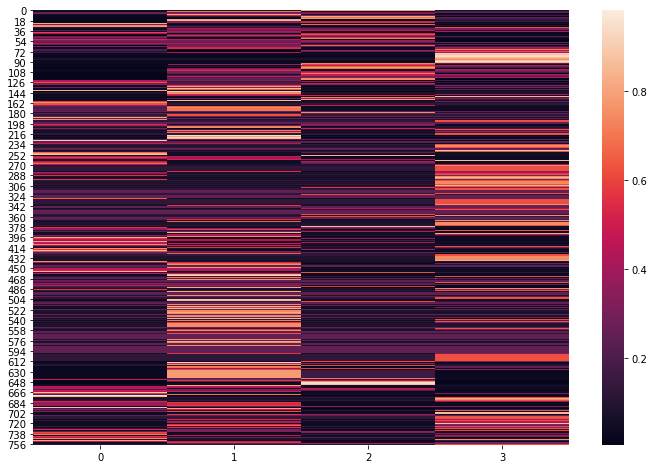

In [12]:
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(document_topic_norm)
plt.show()

In [13]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [14]:
print("\nTopics in LDA model:")
feature_names = vectorizer.get_feature_names()
print_top_words(topic_word, feature_names, 5)


Topics in LDA model:
Topic #1: def return if len while
Topic #2: in for range if append
Topic #3: if elif else input while
Topic #4: import input format int len



### Cálculo da Silhueta ###

2


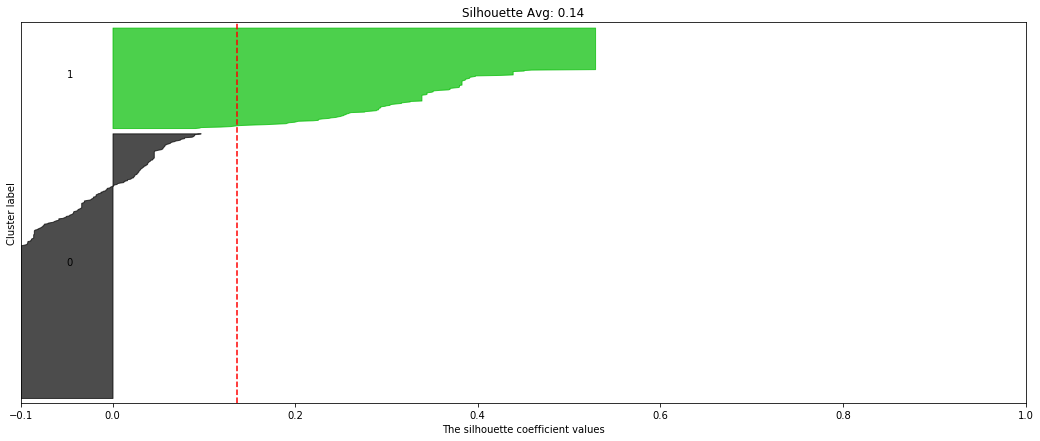

3


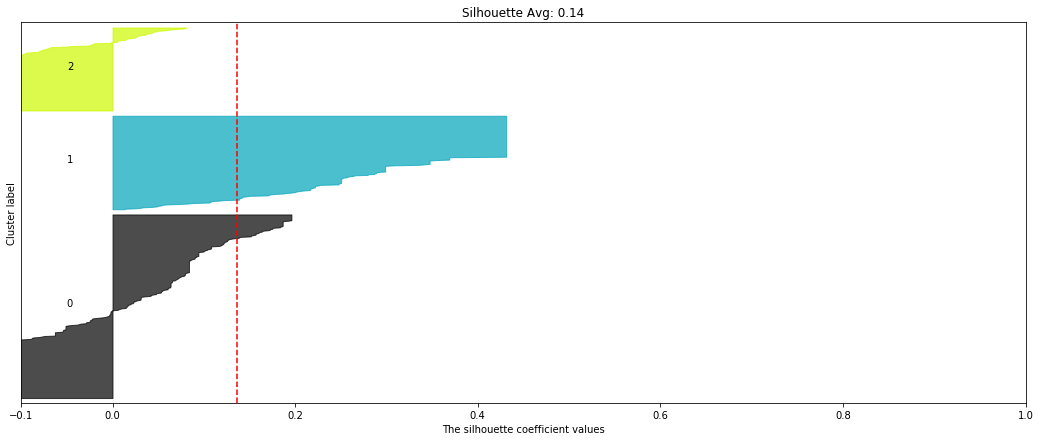

4


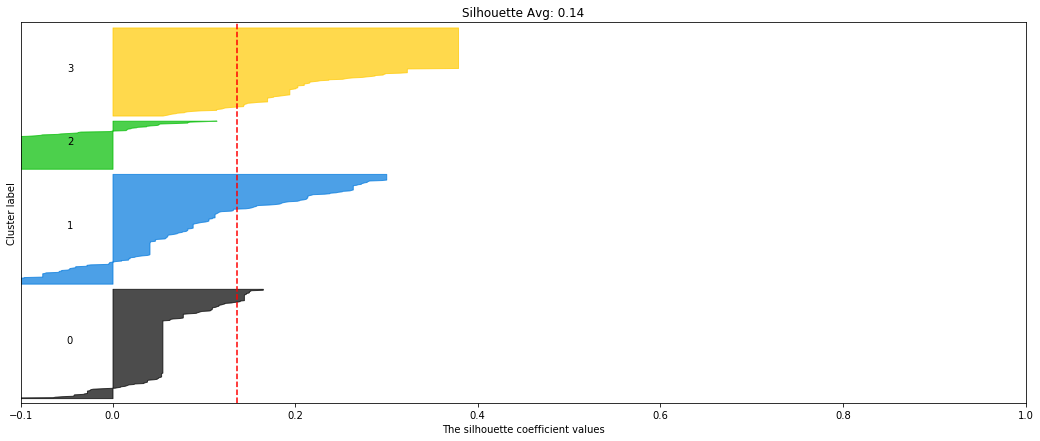

5


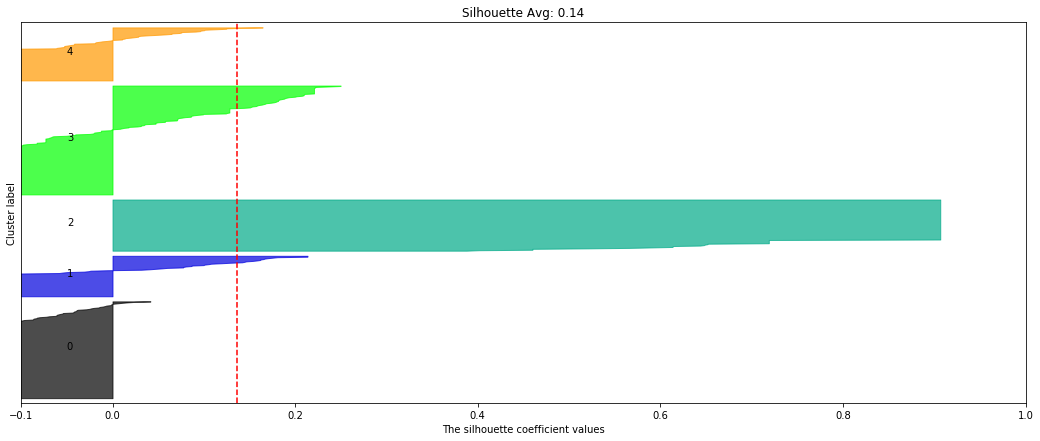

6


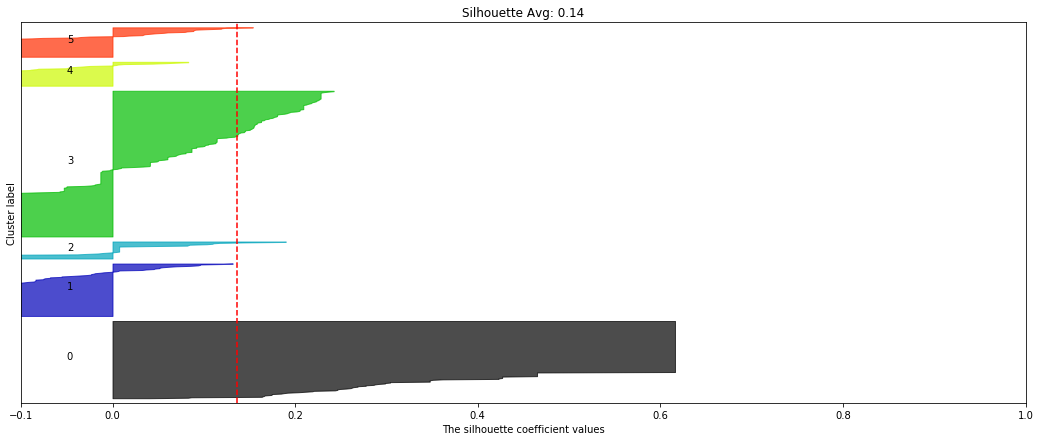

7


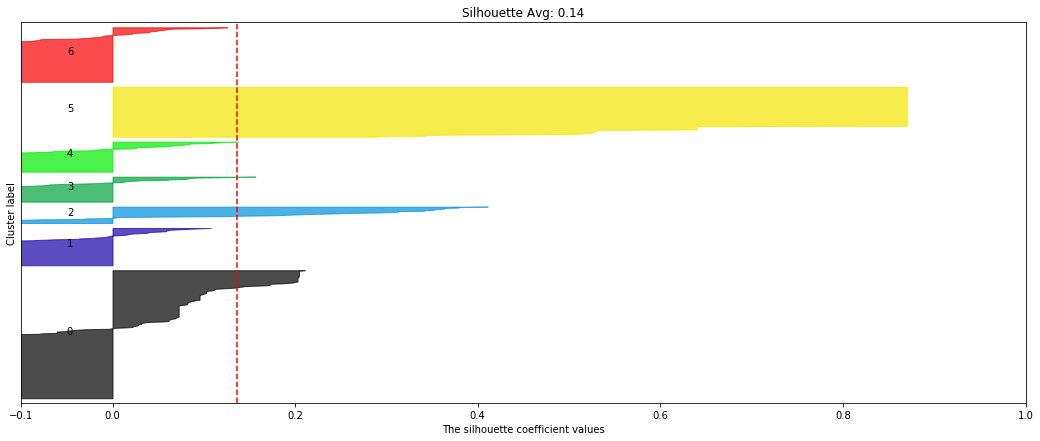

8


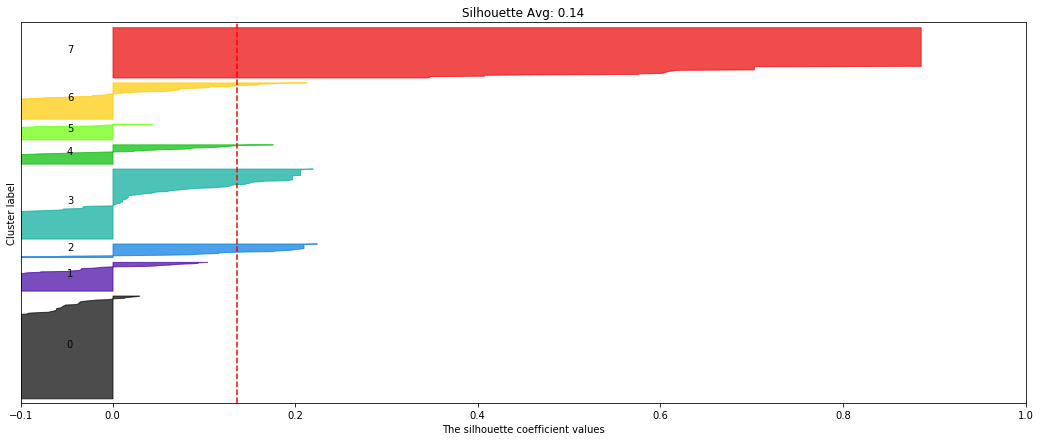

9


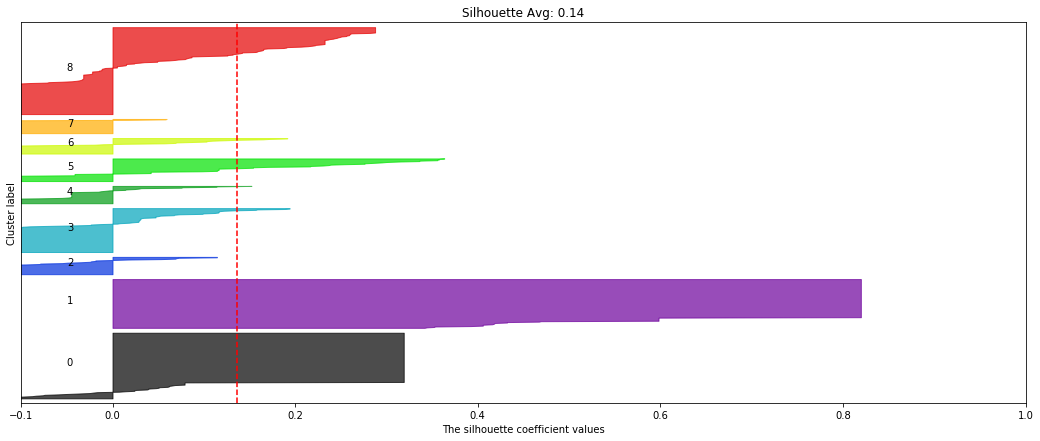

In [16]:
num_topics_sil = range(2, 10)
#num_topics_sil = [50]
# num_topics_sil = [44]
for k in num_topics_sil:
# Compatibility
    X = train_data_features
    n_clusters = k
    cluster_labels = np.argmax(models[k]['document_topic'], axis=1)
    silhouette_avg = models[k]['silhouette']
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 20)
#     fig.set_size_inches(18, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    ax1.set_title("Silhouette Avg: %.2f" % silhouette_avg)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()